# Install Rasterio for Python Import

In [1]:
%pip install rasterio

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



# Imports and Variables 
## Set Files to Use and Output Names Here

In [2]:
import rasterio
import numpy as np
import arcpy
import os
from arcpy import env, CheckOutExtension
from arcpy.sa import *
CheckOutExtension("Spatial")

#set workspace and overwrite option
env.workspace = r'C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\output'
env.overwriteOutput = True

#What is the path for the elevation tif file?
dem = r'C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\input\cormandel_dem25.tif'
#What is the path for the shape file? 
shape = r'C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\input\lakes.shp'


#What name should be prepended to the output polygons?
output_prepend = 'Lakes'

#Should the final polygon be simplified?
#(if True, the final polygon will be smoothed, if False, it will follow the pixel edges)
simplify = True

#How many pixels from original shape should flow be calculated
expand_count = 80

#show working directory
print(os.getcwd()) 
print(env.workspace)

# Check if the dem and shape files exist
if os.path.exists(dem):
    print(f"DEM file found: {dem}")

if os.path.exists(shape):
    print(f"Shape file found: {shape}")

C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject
C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\output
DEM file found: C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\input\cormandel_dem25.tif
Shape file found: C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\input\lakes.shp


## Open the original DEM and save its profile for later use

In [3]:
with rasterio.open(dem) as src:
    # save the georeferencing information for later use
    georeference_metadata = src.profile
georeference_metadata

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 2278, 'height': 3884, 'count': 1, 'crs': CRS.from_wkt('PROJCS["NZGD2000 / New Zealand Transverse Mercator 2000",GEOGCS["NZGD2000",DATUM["New_Zealand_Geodetic_Datum_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6167"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",173],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1600000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 1806964.169031259,
       0.0, -25.0, 5961579.434708128), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

## Use the Fill tool and the FlowDirection tool to create Tiff files for processing

In [4]:
#Fill DEM
print("Filling DEM and saving to output/dem_fill.tif")
dem_fill = arcpy.sa.Fill(dem)
dem_fill

# Use absolute path for saving
output_dem_fill = os.path.join(env.workspace, "dem_fill.tif")
dem_fill.save(output_dem_fill)
print(f"DEM fill saved to: {output_dem_fill}")

#Flow Direction
print("Calculating Flow Direction")
flow_dir = arcpy.sa.FlowDirection(dem_fill)
output_flow_dir = os.path.join(env.workspace, "FlowDir.tif")
flow_dir.save(output_flow_dir)
print(f"Flow direction saved to: {output_flow_dir}")


Filling DEM and saving to output/dem_fill.tif
DEM fill saved to: C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\output\dem_fill.tif
Calculating Flow Direction
Flow direction saved to: C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\output\FlowDir.tif


# Convert shapefile to raster format to enable pixel-based flow analysis

Converting shapefile to raster
Available fields in shapefile:
  FID: OID
  Shape: Geometry
  SUFI: String
  COUNT: Double
  NAME: String
  CREATED_DT: Date
  MODIFIEDDT: Date
  LAKE_TYPE: String
  GROUP_NAME: String
  LAKE_AREA: Double
  LAKE_TOTLR: Double
DEM cell size: 25.0
Values in rasterized shapefile:
  Value: 1, Count: 417
Final raster values:
  Value: 0, Count: 8847335
  Value: 1, Count: 417


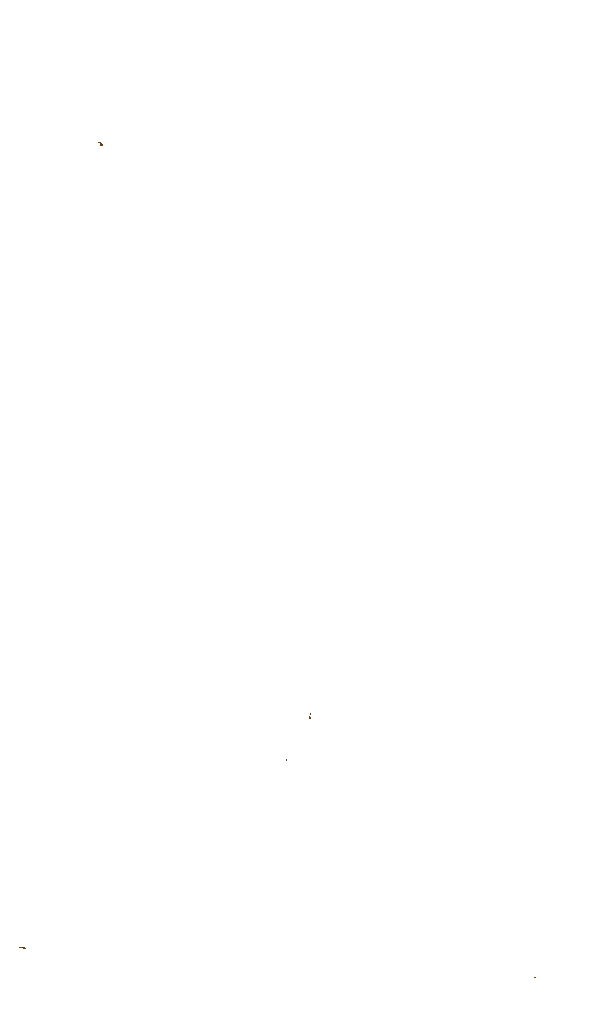

In [5]:

print("Converting shapefile to raster")

# Set processing extent to match the filled DEM for consistent spatial alignment
arcpy.env.extent = dem_fill

# Examine the attribute fields available in the input shapefile
field_list = arcpy.ListFields(shape)
print("Available fields in shapefile:")
for field in field_list:
    print(f"  {field.name}: {field.type}")

# Create a working copy of the shapefile to preserve the original data
shape_copy = os.path.join(env.workspace, "shape_copy.shp")
arcpy.CopyFeatures_management(shape, shape_copy)

# Add a uniform field with value 1 to identify all shape polygons consistently
# This ensures all shape areas have the same raster value after conversion
arcpy.AddField_management(shape_copy, "CONSTANT", "SHORT")
arcpy.CalculateField_management(shape_copy, "CONSTANT", "1", "PYTHON3")

# Extract the cell size from the filled DEM to maintain spatial resolution consistency
with rasterio.open(os.path.join(env.workspace, "dem_fill.tif")) as src:
    dem_cellsize = abs(src.transform[0])  # Get pixel size from transformation matrix

print(f"DEM cell size: {dem_cellsize}")

# Convert polygon features to raster using maximum area method
shape_raster_output = os.path.join(env.workspace, "shape_raster.tif")
shape_raster = arcpy.PolygonToRaster_conversion(shape_copy, "CONSTANT", shape_raster_output, 
                                               "MAXIMUM_AREA", "NONE", dem_cellsize)

# Convert the rasterized data to a NumPy array for numerical processing
shape_raster_array = arcpy.RasterToNumPyArray(shape_raster_output)

# Verify successful conversion by checking the distribution of pixel values
unique_values, counts = np.unique(shape_raster_array, return_counts=True)
print("Values in rasterized shapefile:")
for value, count in zip(unique_values, counts):
    if value != 0:  # Exclude background/NoData pixels
        print(f"  Value: {value}, Count: {count}")

# Write the NumPy array to a georeferenced raster file using the DEM's spatial reference
with rasterio.open(shape_raster_output, 'w', **georeference_metadata) as dst:
    dst.write(shape_raster_array, 1)

# Final validation: confirm the raster contains the expected lake pixel values
shape_raster_array_final = arcpy.RasterToNumPyArray(shape_raster_output)
unique_values, counts = np.unique(shape_raster_array_final, return_counts=True)
print("Final raster values:")
for value, count in zip(unique_values, counts):
    print(f"  Value: {value}, Count: {count}")

# Create an ArcPy raster object for subsequent hydrological analysis
raster = arcpy.Raster(shape_raster_output)
raster

# Convert rasters to arrays and expand shape based on the DEM tiff

In [6]:

shape_raster_path = os.path.join(env.workspace, "shape_raster.tif")
dem_fill_path = os.path.join(env.workspace, "dem_fill.tif")

# Read both rasters as numpy arrays
with rasterio.open(shape_raster_path) as src_shape:
    shape_data = src_shape.read(1).astype(np.int32)

with rasterio.open(dem_fill_path) as src_flow:
    dem_fill_data = src_flow.read(1).astype(np.float32)  # Convert to float to handle inf


rows, cols = shape_data.shape

# Set all cells with value greater than 0 to expand_count
shape_data[shape_data > 0] = expand_count


# Pre-allocate arrays for efficiency
padded_shape = np.pad(shape_data, 1, mode='constant', constant_values=0)
padded_dem = np.pad(dem_fill_data, 1, mode='constant', constant_values=np.inf)

print("Iterations remaining:")

for current_value in range(expand_count, 0, -1):
    if current_value >= 1:
        next_value = current_value - 1
        if current_value % (expand_count * 0.1) == 0:
            print(current_value)
        
        # Find current cells (with padding offset)
        current_cells = (padded_shape == current_value)
        
        if np.any(current_cells):
            # Find all neighbor positions that could be expanded
            candidates = (padded_shape == 0)
            
            # Check 8-connected neighbors efficiently
            for dr in [-1, 0, 1]:
                for dc in [-1, 0, 1]:
                    if dr == 0 and dc == 0:
                        continue
                    
                    # Shift arrays to check neighbors
                    shifted_current = np.roll(np.roll(current_cells, dr, axis=0), dc, axis=1)
                    shifted_dem_current = np.roll(np.roll(padded_dem, dr, axis=0), dc, axis=1)
                    
                    # Find candidates that have current_value neighbors with lower elevation
                    valid_expansion = candidates & shifted_current & (padded_dem >= shifted_dem_current)
                    
                    # Update these cells
                    padded_shape[valid_expansion] = next_value

# Remove padding
shape_data = padded_shape[1:-1, 1:-1]

# Convert all non-zero pixels to 1 while leaving zero pixels as 0
shape_data[shape_data != 0] = 1

# Save the updated array
new_shape_array_path = os.path.join(env.workspace, "new_shape_array.tif")
with rasterio.open(new_shape_array_path, 'w', **georeference_metadata) as dst:
    dst.write(shape_data, 1)

print(f"Updated shape array saved as '{new_shape_array_path}'")

# Verify the final result
shape_raster_array_final = arcpy.RasterToNumPyArray(new_shape_array_path)
unique_values, counts = np.unique(shape_raster_array_final, return_counts=True)
print("Final raster values:")
for value, count in zip(unique_values, counts):
    print(f"  Value: {value}, Count: {count}")

Iterations remaining:
80
72
64
56
48
40
32
24
16
8
Updated shape array saved as 'C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\output\new_shape_array.tif'
Final raster values:
  Value: 0, Count: 8755518
  Value: 1, Count: 92234


In [7]:
# Convert Rasters to arrays and expand the shape based on the Flow Direction tiff

In [8]:
def likely_shape():

    # Read shape raster
    with rasterio.open(os.path.join(env.workspace, 'shape_raster.tif')) as src_shape:
        shape_data = src_shape.read(1).astype(np.int32)

    # Read flow direction raster
    with rasterio.open(os.path.join(env.workspace, 'FlowDir.tif')) as src_flow:
        flow_data = src_flow.read(1).astype(np.int32)  

    # Initialize shape data - set initial shape pixels to expand_count
    shape_data[shape_data > 0] = expand_count
    
    # Create padded arrays for edge handling
    padded_shape = np.pad(shape_data, 1, mode='constant', constant_values=0)
    padded_flow = np.pad(flow_data, 1, mode='constant', constant_values=0)
    
    print("Processing with flow direction expansion:")
    print("Iterations remaining:")
    
    # ArcGIS flow direction values and corresponding shift directions
    # 1=E, 2=SE, 4=S, 8=SW, 16=W, 32=NW, 64=N, 128=NE
    flow_shifts = {
        1: (0, 1),    # Flow East -> coming from West
        2: (1, 1),    # Flow Southeast -> coming from Northwest
        4: (1, 0),    # Flow South -> coming from North
        8: (1, -1),   # Flow Southwest -> coming from Northeast
        16: (0, -1),  # Flow West -> coming from East
        32: (-1, -1), # Flow Northwest -> coming from Southeast
        64: (-1, 0),  # Flow North -> coming from South
        128: (-1, 1)  # Flow Northeast -> coming from Southwest
    }
    
    
    # Iteratively expand the shape
    for current_value in range(expand_count, 0, -1):
        if current_value % (expand_count * 0.1) == 0:
            print(current_value)
            
        next_value = current_value - 1
        
        # Find cells with current value
        current_cells = (padded_shape == current_value)
        
        if not np.any(current_cells):
            continue
            
        # Find candidate cells (value = 0)
        candidates = (padded_shape == 0)
        
        # For each flow direction, check if candidates flow toward current cells
        for flow_val, (dr, dc) in flow_shifts.items():
            # Find candidates with this flow direction
            flow_candidates = candidates & (padded_flow == flow_val)
            
            if not np.any(flow_candidates):
                continue
                
            # Check if these candidates flow toward a current cell
            target_is_current = np.roll(np.roll(current_cells, -dr, axis=0), -dc, axis=1)
            
            # Valid expansion: candidate cells that flow toward current cells
            valid_expansion = flow_candidates & target_is_current
            
            # Update these cells
            padded_shape[valid_expansion] = next_value
    
    # Remove padding
    shape_data = padded_shape[1:-1, 1:-1]
    
    # Convert all non-zero pixels to 1
    shape_data[shape_data != 0] = 1
    
    # Save the updated array
    output_new_shape = os.path.join(env.workspace, 'new_shape_array_likely.tif')
    with rasterio.open(output_new_shape, 'w', **georeference_metadata) as dst:
        dst.write(shape_data, 1)
        
    print(f"Updated shape array saved as '{output_new_shape}'")
    
    # Verify the final result
    shape_raster_array_final = arcpy.RasterToNumPyArray(output_new_shape)
    unique_values, counts = np.unique(shape_raster_array_final, return_counts=True)
    print("Final raster values:")
    for value, count in zip(unique_values, counts):
        print(f"  Value: {value}, Count: {count}")



### Call the likely_shape function.
### Process was made into a function for future improvements

In [9]:
likely_shape()

Processing with flow direction expansion:
Iterations remaining:
80
72
64
56
48
40
32
24
16
8
Updated shape array saved as 'C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\output\new_shape_array_likely.tif'
Final raster values:
  Value: 0, Count: 8835812
  Value: 1, Count: 11940


# Convert the resulting rasters to polygon shapes and save them as shp files in the output folder.
## Clean up variables and temp files

In [10]:
# Function to convert raster to polygon shapefile, used for both Possible and Likely tif conversions
def convert_raster_to_polygon(input_raster, output_shapefile):
    print(f"Converting {os.path.basename(input_raster)} to shapefile")
    temp_polygon = os.path.join(env.workspace, f"temp_{os.path.basename(output_shapefile)}")

    # Ensure the raster is of integer type
    int_raster = os.path.join(env.workspace, "int_raster.tif")
    arcpy.sa.Int(input_raster).save(int_raster)

    # Convert raster to polygon
    arcpy.RasterToPolygon_conversion(int_raster, temp_polygon, simplify, "VALUE")
    print(f"Raster converted to temporary shapefile: {temp_polygon}")

    # Create a feature layer and select only polygons with gridcode > 0
    arcpy.MakeFeatureLayer_management(temp_polygon, "temp_layer")
    arcpy.SelectLayerByAttribute_management("temp_layer", "NEW_SELECTION", "gridcode > 0")

    # Export selected features to a new shapefile
    arcpy.CopyFeatures_management("temp_layer", output_shapefile)
    print(f"Final shapefile saved as: {output_shapefile}")

    # Clean up temporary layer
    arcpy.Delete_management("temp_layer")
    arcpy.Delete_management(temp_polygon)
    arcpy.Delete_management(int_raster)

    return temp_polygon

# Define input and output paths
array_raster = os.path.join(env.workspace, "new_shape_array.tif")
likely_array_raster = os.path.join(env.workspace, "new_shape_array_likely.tif")
final_polygon = os.path.join(env.workspace, output_prepend+"_rh_polygon.shp")
final_likely_polygon = os.path.join(env.workspace, output_prepend+"_rh_polygon_likely.shp")

# Convert both rasters to shapefiles
temp_polygon1 = convert_raster_to_polygon(array_raster, final_polygon)
temp_polygon2 = convert_raster_to_polygon(likely_array_raster, final_likely_polygon)

# Clean up all temporary files
print("Cleaning up temporary files...")
temp_files = [
    temp_polygon1,
    temp_polygon2,
    array_raster,
    likely_array_raster,
    os.path.join(env.workspace, "dem_fill.tif"),
    os.path.join(env.workspace, "shape_raster.tif"),
    os.path.join(env.workspace, "shape_copy.shp"),
    os.path.join(env.workspace, "FlowDir.tif")
]

for file in temp_files:
    try:
        arcpy.Delete_management(file)
    except:
        print(f"Could not delete {file}")

# Clear any remaining temporary workspace objects
arcpy.ClearWorkspaceCache_management(env.workspace)
print("Temporary files deleted and final shapefiles created.")
print(f"Final shapefiles saved as: {final_polygon} and {final_likely_polygon}")

Converting new_shape_array.tif to shapefile
Raster converted to temporary shapefile: C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\output\temp_Lakes_rh_polygon.shp
Final shapefile saved as: C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\output\Lakes_rh_polygon.shp
Converting new_shape_array_likely.tif to shapefile
Raster converted to temporary shapefile: C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\output\temp_Lakes_rh_polygon_likely.shp
Final shapefile saved as: C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\output\Lakes_rh_polygon_likely.shp
Cleaning up temporary files...
Temporary files deleted and final shapefiles created.
Final shapefiles saved as: C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\538_Projects\FinalProject\output\Lakes_rh_polygon.shp and C:\Users\ss2596\OneDrive - The University of Waikato\ArcGIS\5